## Load libraries

In [1]:
import numpy as np
import pandas as pd
import math
import pickle
import json
from gurobipy import *
from datetime import datetime

## Functions

In [2]:
def pickle_load(file_dir):
  with open(file_dir, "rb") as fp:   # Unpickling
    return pickle.load(fp)

def json_load(file_dir):
    with open(file_dir) as f:
        return json.load(f)

In [3]:
data_dir = './data/'

# scenario number & distribution settings
scenario_num = 100
distribution_choice = 'normal'

# Sets directory
Bset_dir = data_dir + 'Bset.txt'
Bij_set_dir = data_dir + 'Bij_set.txt'
Sset_dir = data_dir+'Sset_' + str(scenario_num) + '.txt'

deterministic_params_dir = data_dir + 'deterministic_params.json'
capacity_i_dir = data_dir + 'capacity_i.json'
capacity_i_constant_dir = data_dir + 'capacity_i_constant.json'

p_s_dir = data_dir + 'p_s_' + str(scenario_num) + '.json'
demScens_dir = data_dir + 'demScens_' + distribution_choice + '_' + str(scenario_num) + '.dict'

In [4]:
# Sets
Bset = pickle_load(Bset_dir)                                  # 22 Bike Stations
Bij_set = pickle_load(Bij_set_dir)                                  # Bike pairs                                        
Sset = pickle_load(Sset_dir)                                     # Scenario sets
deterministic_params = json_load(deterministic_params_dir)       # deterministic parameters

c = deterministic_params['c']                            # unit procurement cost
v_i = deterministic_params['v_i']                               # stock-out cost
w_i = deterministic_params['w_i']                              # time-waste cost 
t_ij = deterministic_params['t_ij']                    # unit transshipment cost 
capacity_i = json_load(capacity_i_dir)
p_s = json_load(p_s_dir)
demScens = pickle_load(demScens_dir)

In [5]:
cpy = {}
for pair, val in demScens.items():
    cpy[((pair[0], pair[1]), pair[2])] = val
demScens = cpy

In [6]:
t_ij

1

The formulation of the two-stage stochastic program problem i written as follows:

<b>First stage varibles:</b> <br>
$$x_i: \text{the number of bikes to assign to bike-station i} \in \text{B at the beginning of the service}$$
<b>Second stage variables: </b>
$$
\beta_{ijs}: \text{Number of rented bikes from bike-station i to bike-station j in scenario s}\\
I_{is}^{+}: \text{Realized surplus of bikes at bike-station i in scenario s} \\
I_{ijs}^{-}: \text{Realized shortage of bikes at origin-destination pair i, j in scenario s}\\
\rho_{ijs}: \text{Number of redirected bikes from bike-station i to bike-station j in scenario s (in case of overflow)}\\
O_{is}^{+}: \text{Residual capacity at bike-station i in scenario s} \\
O_{is}^{-}: \text{Overflow at bike-station i in scenario s} \\
\tau_{ijs}: \text{Number of transshipped bikes from bike-station i to bike-station j in scenario s} \\
T_{is}^{+}: \text{Excess of bikes at bike-station i in scenario s} \\
T_is^{-}: \text{Lack of bikes at bike-station i in scenario s} \\
$$

<b>Formulation:</b>
$$
\begin{align*}
    \text{minimize: }   & c \sum_{i}^B x_i + \sum_{s=1}^S p_s\sum_{i=1}^B [v_i\sum_{j=1}^B I_{ijs}^{-} + w_iO_{is}^{-} + \sum_{j=1}^B t_{ij}\tau_{ijs}]\\
    \text{subject to: }   
        & x_{i} \le k_i, \forall i \in B &\text{(Bike Station Capacity)}\\
        & \beta_{ijs} = \xi_{ijs} - I_{ijs}^{-} , \forall i,j \in B, s \in S &\text{(rented bike successfully made from station i to j)}\\
        & I_{is}^{+} - \sum_{j=1}^B I_{ijs}^{-} = x_i - \sum_{j=1}^B \xi_{ijs} , \forall i \in B, s \in S &\text{(realized surplus and shortage)}\\
        & O_{is}^{+} - O_{is}^{-} = k_i - x_i + \sum_{j=1}^B \beta_{ijs} - \sum_{j=1}^B \beta_{ijs}, \forall i \in B, s \in S &\text{(residual capacity and overflow after rental)}\\
        & \sum_{j=1}^{B} \rho_{ijs} = O_{is}^{-}, \forall i \in B, s \in S &\text{(Redirection identifies station overflow)}\\
        & \sum_{j=1}^{B} \rho_{jis} \le O_{is}^{+}, \forall i \in B, s \in S &\text{(Sucessful redirection less than residual capacity)}\\
        & T_{is}^{+} - T_{is}^{-} = k_i - O_{is}^{+} + \sum_{j=1}^{B}\rho_{jis} - x_i, \forall i \in B, s \in S &\text{(Excess and Lack of bikes at stations)}\\
        & \sum_{j=1}^{B}\tau_{ijs} = T_{is}^{+}, \forall i \in B, s \in S &\text{(Transshipment of excessive bikes)}\\
        & \sum_{j=1}^{B}\tau_{jis} = T_{is}^{-}, \forall i \in B, s \in S &\text{(Transshipment fulfillment)}\\
        & x_i, I_{is}^{+}, O_{is}^{+}, O_{is}^{-}, T_{is}^{+}, T_{is}^{-} \in \mathbb{Z}^{+}, \forall i \in B, s \in S\\
        & \tau_{ijs}, \beta_{ijs}, \rho_{ijs}, I_{ijs}^{-} \in \mathbb{Z}^{+}, , \forall i,j \in B, s \in S\\
\end{align*}
$$

## Building Model

In [7]:
MP = Model("Master Problem")
CutViolationTolerance = 0.0001

Using license file /Users/ruijian/gurobi.lic
Academic license - for non-commercial use only


### Set variables

In [8]:
# first stage variables
x = MP.addVars(Bset, vtype=GRB.INTEGER, name='x')

eta = MP.addVars(Sset, name="eta")

MP.addConstrs((x[i] <= capacity_i[i] for i in Bset), name="capacity constr")

MP.setObjective(c*quicksum(x[i]for i in Bset) \
               + quicksum(p_s[s]*eta[s] for s in Sset) )

### Set modelsense

In [9]:
MP.modelSense = GRB.MINIMIZE
MP.Params.outputFlag = 0  # turn off output
MP.params.logtoconsole=0  # turn off logging of process 

### Build subproblem

In [10]:
# second stage variables
SP = Model("SP")
SP.Params.outputFlag = 0  # turn off output
SP.params.logtoconsole=0  # turn off logging of process 


beta_ij = SP.addVars(Bset, Bset, name='beta_ij')
I_i_surplus = SP.addVars(Bset, name='I_ij_surplus')
I_ij_shortage = SP.addVars(Bset,Bset, name='I_ij_shortage')
rho_ij = SP.addVars(Bset,Bset, name='rho_ij')
O_i_resCap = SP.addVars(Bset, name='O_i_resCap')
O_i_overF = SP.addVars(Bset, name='O_i_overF')
tau_ij = SP.addVars(Bset,Bset, name='tau_ij')
T_i_excess = SP.addVars(Bset, name='T_i_excess')
T_i_lack = SP.addVars(Bset, name='T_i_lack')

SP.setObjective(quicksum(v_i * I_ij_shortage.sum(i,'*')\
                                          + w_i * O_i_overF[i] \
                                          + t_ij * tau_ij.sum(i, '*') for i in Bset))

In [11]:
a_plus_constr = {}
a_minus_constr = {}
b_plus_constr = {}
b_minus_constr = {}
c_plus_constr = {}
c_minus_constr = {}
d_constr = {}
e_constr = {}
f_plus_constr = {}
f_minus_constr = {}
g_constr = {}
h_constr = {}

### Set constraints

In [12]:
for ij in Bij_set:
    a_plus_constr[ij] = SP.addConstr(beta_ij[ij] + I_ij_shortage[ij] <= 0, name="a_plus_"+str(ij))
    a_minus_constr[ij] = SP.addConstr(-beta_ij[ij] - I_ij_shortage[ij] <= 0, name="a_minus_"+str(ij))

In [13]:
for i in Bset:
    b_plus_constr[i] = SP.addConstr(I_i_surplus[i] - I_ij_shortage.sum(i, '*') <= 0, name="b_plus_"+str(i))
    b_minus_constr[i] = SP.addConstr(-I_i_surplus[i] + I_ij_shortage.sum(i, '*') <= 0, name="b_minus_"+str(i))

In [14]:
for i in Bset:
    c_plus_constr[i] = SP.addConstr(O_i_resCap[i] - O_i_overF[i] \
                                    -beta_ij.sum(i, '*') + beta_ij.sum('*', i) <= 0, name="c_plus_"+str(i))
    c_minus_constr[i] = SP.addConstr(-O_i_resCap[i] + O_i_overF[i] \
                                    +beta_ij.sum(i, '*') - beta_ij.sum('*', i) <= 0, name="c_minus_"+str(i))

In [15]:
for i in Bset:
    d_constr[i] = SP.addConstr(rho_ij.sum(i, '*') == O_i_overF[i], name="d_"+str(i))

In [16]:
for i in Bset:
    e_constr[i] = SP.addConstr(rho_ij.sum('*', i) <= O_i_resCap[i], name="e_"+str(i))  

In [17]:
for i in Bset:
    f_plus_constr[i] = SP.addConstr(T_i_excess[i] - T_i_lack[i] \
                                    + O_i_resCap[i] - rho_ij.sum('*', i) <= 0, name="f_plus_"+str(i))
    f_minus_constr[i] = SP.addConstr(-T_i_excess[i] + T_i_lack[i] \
                                    - O_i_resCap[i] + rho_ij.sum('*', i) <= 0, name="f_minus_"+str(i))

In [18]:
for i in Bset:
    g_constr[i] = SP.addConstr(tau_ij.sum(i, '*') == T_i_excess[i], name='g_'+str(i))

In [19]:
for i in Bset:
    h_constr[i] = SP.addConstr(tau_ij.sum('*', i) == T_i_lack[i], name="h_"+str(i))

In [20]:
def ModifyAndSolveSP(s, single=False):
    # Modify constraint rhs and update
    for ij in Bij_set:
        a_plus_constr[ij].rhs = demScens[(ij, s)]
        a_minus_constr[ij].rhs = -demScens[(ij, s)]
        SP.update()
    for i in Bset:
        b_plus_constr[i].rhs = x_sol[i] - sum([demScens[(i, j), s] for j in Bset])
        b_minus_constr[i].rhs = -(x_sol[i] - sum([demScens[(i, j), s] for j in Bset]))
        SP.update()
    for i in Bset:
        c_plus_constr[i].rhs = capacity_i[i] - x_sol[i]
        c_minus_constr[i].rhs = -(capacity_i[i] - x_sol[i])
        SP.update()
    for i in Bset:
        f_plus_constr[i].rhs = capacity_i[i] - x_sol[i]
        f_minus_constr[i].rhs = -(capacity_i[i] - x_sol[i])
        SP.update()
        
#     SP.write("myfile.lp")
        
    # Solve and get the DUAL solution
    SP.optimize()
    
    # Get dual variable solutions
    a_plus_sol = {ij: a_plus_constr[ij].Pi for ij in Bij_set}
    a_minus_sol = {ij: a_minus_constr[ij].Pi for ij in Bij_set}
    
    b_plus_sol = {i: b_plus_constr[i].Pi for i in Bset}
    b_minus_sol = {i: b_minus_constr[i].Pi for i in Bset}
    
    c_plus_sol = {i: c_plus_constr[i].Pi for i in Bset}
    c_minus_sol = {i: c_minus_constr[i].Pi for i in Bset}
    
    f_plus_sol = {i: f_plus_constr[i].Pi for i in Bset}
    f_minus_sol = {i: f_minus_constr[i].Pi for i in Bset}
    

    SPobj = SP.objVal

    # Check whether a violated Benders cut is found for multi-cut benders
    CutFound = False
    if(single == False and eta_sol[s] < SPobj - CutViolationTolerance): # Found Benders cut is violated at the current master solution
        CutFound = True

    return SPobj, CutFound, a_plus_sol, a_minus_sol, b_plus_sol, b_minus_sol, c_plus_sol, c_minus_sol, f_plus_sol, f_minus_sol

In [21]:
CutFound = True
NoIters = 0
MaxIters = 5000
BestUB = GRB.INFINITY
BestLB = -GRB.INFINITY
start=datetime.now()
totalNumCut = 0

LB_lst = []
UB_lst = []
cuts = []
while(CutFound and NoIters < MaxIters):
    NoIters += 1
    CutFound = False
    
    print("----------------------------Iteration: %d ----------------------------" %NoIters)

    # Solve MP
    MP.update()
    MP.optimize()

    # Get MP solution
    MPobj = MP.objVal
    print('MPobj: %g' % MPobj)

    # get x_a^hat
    x_sol = {i: x[i].x for i in Bset}

    eta_sol = {s: eta[s].x for s in Sset}     
    
    LB = MPobj
    UB = c * sum([x_sol[i] for i in Bset])   # Get first stage part for the solution 
    num_cut = 0
    
    #loop through scenarios 
    for s in Sset:
        Qvalue, CutFound_s, a_plus_sol, a_minus_sol, b_plus_sol, b_minus_sol, c_plus_sol, c_minus_sol, f_plus_sol, f_minus_sol = ModifyAndSolveSP(s)
        UB += p_s[s] * Qvalue
        
        # if cut found for current scenario
        if(CutFound_s):
            CutFound = True
 
            
            expr = LinExpr(eta[s] - quicksum(demScens[(ij, s)]*a_plus_sol[ij] for ij in Bij_set)\
                           +quicksum(demScens[(ij, s)]*a_minus_sol[ij] for ij in Bij_set)\
                           -quicksum((x[i] - sum([demScens[(i, j), s] for j in Bset])) * b_plus_sol[i] for i in Bset)\
                           +quicksum((x[i] - sum([demScens[(i, j), s] for j in Bset])) * b_minus_sol[i] for i in Bset)\
                           -quicksum((capacity_i[i] - x[i]) * c_plus_sol[i] for i in Bset)\
                           +quicksum((capacity_i[i] - x[i]) * c_minus_sol[i] for i in Bset)\
                           -quicksum((capacity_i[i] - x[i]) * f_plus_sol[i] for i in Bset)\
                           +quicksum((capacity_i[i] - x[i]) * f_minus_sol[i] for i in Bset))

            
            # add in cuts, for here is only adding one single cut 
            MP.addConstr(expr >= 0, "eta_constr_"+str(s)+"_"+str(NoIters))
            num_cut += 1
    
    # Update LB and UB 
    if(UB < BestUB):
        BestUB = UB
    if(LB > BestLB):
        BestLB = LB
        
    LB_lst.append(LB)
    UB_lst.append(UB)
    cuts.append(num_cut)
    print("LB: " + str(LB))
    print("UB: " + str(UB) + "\n")
    print("Number of cut added: " + str(num_cut) + "\n")
    totalNumCut += num_cut

print('\nOptimal Solution:')
print("Algorithm duration:", datetime.now()-start)
print('MPobj: %g' % MPobj)
print("BestLB: " + str(BestLB) + "\n")
print("BestUB: " + str(BestUB) + "\n")
print("NoIters: " + str(NoIters))
print("Total number of cuts added: " + str(totalNumCut))

----------------------------Iteration: 1 ----------------------------
MPobj: 0
LB: 0.0
UB: 922.7297608000001

Number of cut added: 100

----------------------------Iteration: 2 ----------------------------
MPobj: 424.024
LB: 424.0240471999999
UB: 792.9301880999998

Number of cut added: 100

----------------------------Iteration: 3 ----------------------------
MPobj: 424.888
LB: 424.88781939999984
UB: 693.7812904

Number of cut added: 100

----------------------------Iteration: 4 ----------------------------
MPobj: 449.345
LB: 449.3447088
UB: 653.997961

Number of cut added: 100

----------------------------Iteration: 5 ----------------------------
MPobj: 497.442
LB: 497.44226270000036
UB: 661.3770032999998

Number of cut added: 100

----------------------------Iteration: 6 ----------------------------
MPobj: 504.279
LB: 504.27891490000013
UB: 651.174937

Number of cut added: 100

----------------------------Iteration: 7 ----------------------------
MPobj: 512.018
LB: 512.0177454999999


NameError: name 'exponential_ln' is not defined

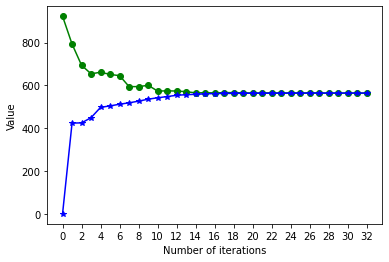

In [44]:
sub = np.load("scutub.npy")
slb = np.load("scutlb.npy")

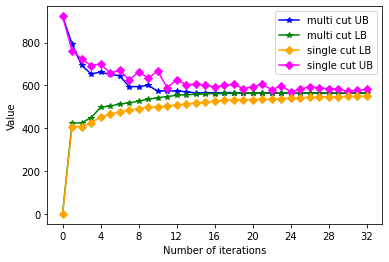

In [45]:
import matplotlib.pyplot as plt
l = len(UB_lst)
plt.xlabel('Number of iterations') 
plt.ylabel('Value')
x = np.arange(len(UB_lst))
plt.xticks(range(0, len(UB_lst), 4))
mub, = plt.plot(x,UB_lst, marker='*', color='blue', label='multi cut UB')
mlb, = plt.plot(x,LB_lst, marker='*', color='green', label='multi cut LB')
sub, = plt.plot(x,sub[:l], marker='D', color='magenta', label='single cut UB')
slb, = plt.plot(x,slb[:l], marker='D', color='orange', label='single cut LB')
plt.legend(handles=[mub, mlb, slb, sub])

plt.show()

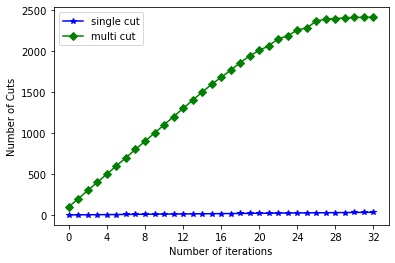

In [53]:
plt.xlabel('Number of iterations') 
plt.ylabel('Number of Cuts')
l = len(UB_lst)
x = np.arange(l)
plt.xticks(range(0, len(UB_lst), 4))
single, = plt.plot(x, x, marker='*', color='blue', label='single cut')
mult, = plt.plot(x, np.cumsum(cuts), marker='D', color='green', label="multi cut")
plt.legend(handles=[single, mult])

plt.show()

In [54]:
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])